Rishikesan (Rishi) Ravichandran


In [1]:
import pandas as pd
import py7zr
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm

from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss
import warnings

In [2]:
#Getting the file 

# Path to claims .7z file
file_path = './longyear-obese-hypertensive-40-57-medical-SMALL-sample.7z'

# Open the .7z file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    all_files = z.getnames()
    print(all_files)
    # Assuming there's only one CSV file in the .7z archive
    csv_file_name = all_files[0]
    # Extract the CSV file to memory
    csv_file_dict = z.read([csv_file_name])
    csv_file = csv_file_dict[csv_file_name]


# Load the CSV data into a pandas DataFrame
claims = pd.read_csv(csv_file)

#Path to prescription dataset 
file_path = 'longyear-obese-hypertensive-40-75-scripts-SMALL-sample.7z'

# Open the .7z file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    all_files = z.getnames()
    # Assuming there's only one CSV file in the .7z archive
    csv_file_name = all_files[0]
    # Extract the CSV file to memory
    csv_file_dict = z.read([csv_file_name])
    csv_file = csv_file_dict[csv_file_name]

# Load the CSV data into a pandas DataFrame
pres = pd.read_csv(csv_file)

['longyear-obese-hypertensive-40-57-medical-SMALL-sample.csv']


/var/folders/6_/dr76lzfx6k97z9ld6s_cvxs00000gn/T/ipykernel_32658/1306451286.py:33: DtypeWarning: Columns (9,10,29,43) have mixed types. Specify dtype option on import or set low_memory=False.
  pres = pd.read_csv(csv_file)


## Task 1. Exploratory Data Analysis (EDA)

The main idea is to analyze the data at hand without dwelling too much into data processing (or feature engineering).

In [3]:
#Display the claims data 
claims.head()

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,diag_4,diag_5,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed
0,00006390c96ebfffed580074c35a16a7,d5e15811af1d772f54af52f3560be0a5,f22b7ab885c44afae5449d74f8498f53aea1b2cfa79598...,d5a7dc61071d977cef9ff762973d360f4bcf15a19790d9...,2020-07-13,CA,922.0,55.0,M,Home,...,NaN,NaN,NaN,1.0,A6549,NU,2.0,300.00,300.00,974.13
1,00006390c96ebfffed580074c35a16a7,d5e15811af1d772f54af52f3560be0a5,f22b7ab885c44afae5449d74f8498f53aea1b2cfa79598...,d5a7dc61071d977cef9ff762973d360f4bcf15a19790d9...,2020-07-13,CA,922.0,55.0,M,Home,...,NaN,NaN,NaN,1.0,A6549,NU,2.0,300.00,300.00,974.13
2,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3074F,NaN,1.0,0.00,0.00,46.57
3,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3078F,NaN,1.0,0.00,0.00,56.38
4,00006d564a4718c744f1bbf1b6c5f8c3,42ba4419d9ad7c9293d76686fb608f10,9e4534892128401c693a6ab2ea758cd6a0a6484972168b...,da5cef18317c14180ed561a84001d8a033d724d541a2c0...,2023-08-11,CA,900.0,55.0,F,Independent Laboratory,...,NaN,NaN,NaN,1.0,80053,NaN,1.0,88.07,88.07,15.16


In [4]:
#Display all the columns in claims data
claims.columns

Index(['journey_id', 'episode_id', 'visit_id', 'encounter_id', 'claim_date',
       'patient_state', 'patient_short_zip', 'patient_age', 'patient_gender',
       'place_of_service', 'visit_type', 'payor', 'payor_channel', 'ref_npi',
       'hcp_npi', 'hcp_taxonomy', 'hcp_specialty', 'hco_npi', 'hcp_npi_list',
       'hco_npi_list', 'diag_list', 'diag_1', 'diag_2', 'diag_3', 'diag_4',
       'diag_5', 'rev_center_code', 'rev_center_units', 'proc_code',
       'proc_modifier', 'proc_units', 'line_charge', 'claim_charge',
       'smart_allowed'],
      dtype='object')

In [5]:
#Number of unique patients observed. 
print(f"The number of patients observed under the claims data is {len(claims['journey_id'].unique())}.")


The number of patients observed under the claims data is 27377.


This is an important information, as we can only observe the effect of ozyempic in successive 
visits of a patient, as that is intutively true for the study of effects of most medications.

In [6]:
#Since our goal is understand the effects of Ozempic on Obese or Hypertensive patients, so a patient first gotta be diagnosed with these, 
#so let's filter the data for the same

#Filter only Obese: E66, and hypertension: I10, get the ids of patients who were obese or hypertensive at any point of their journey
pt_interest = claims[claims['diag_list'].str.contains('E66|I10', na=False)]['journey_id'].unique()

data = claims[claims['journey_id'].isin(pt_interest)]

In [7]:
data

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,diag_4,diag_5,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed
4,00006d564a4718c744f1bbf1b6c5f8c3,42ba4419d9ad7c9293d76686fb608f10,9e4534892128401c693a6ab2ea758cd6a0a6484972168b...,da5cef18317c14180ed561a84001d8a033d724d541a2c0...,2023-08-11,CA,900.0,55.0,F,Independent Laboratory,...,NaN,NaN,NaN,1.0,80053,NaN,1.0,88.07,88.07,15.16
5,00006d564a4718c744f1bbf1b6c5f8c3,cad5e8635fd011bfec2b65d161b15254,3b0f0f71ac05c34ab9307c4853f1af59420c07b522cdf2...,eafff3ebf33ebe534edc66e761d9b52d1381653d9d0d57...,2019-11-01,CA,900.0,50.0,F,Office,...,M4317,N200,NaN,1.0,72072,NaN,1.0,107.00,107.00,72.42
6,00006d564a4718c744f1bbf1b6c5f8c3,cfc123a94e0e7687f5970ef10298b4f3,b058872fef09e56b8cb2884d0efb176b40d74e0ab9958f...,40a7b91c3e29dd785065e3b6377d7f92303c442cb0df99...,2022-09-16,CA,900.0,50.0,F,Office,...,Z6825,NaN,NaN,1.0,1159F,NaN,1.0,0.01,0.01,44.68
7,00006d564a4718c744f1bbf1b6c5f8c3,19bcb45f2fd320d43dd38f830984b2b9,a57068de153766ca711558b032f098755599f34648fae5...,6bc65d28fcc6a1864cd0fa9a21bee994ae9f0ad6c56469...,2022-12-23,CA,900.0,50.0,F,Office,...,NaN,NaN,NaN,1.0,71046,NaN,1.0,93.00,93.00,99.16
8,00006d564a4718c744f1bbf1b6c5f8c3,19bcb45f2fd320d43dd38f830984b2b9,822e380adc05d2abf61dcaec34262c891e5bd7da0a4cc7...,2ffddae22ec5dc0a6ee2b9ae6efdb8222acec2d649db15...,2023-01-03,CA,900.0,55.0,F,Office,...,NaN,NaN,NaN,1.0,76775,NaN,1.0,209.00,209.00,128.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623520,1fffbb8b7e6a6c38cf97dafe3c5bc1cc,68f555e03ccddc02c78db02eab162c73,c45c2ba5fa8c97f5dd9e39064496898a54e7c82624ac9e...,c571d6153d7948e36a32fdc69dd974676473d9496772a6...,2023-01-04,CA,922.0,50.0,M,Office,...,K449,NaN,NaN,1.0,99213,NaN,1.0,175.00,175.00,83.22
623521,1fffbb8b7e6a6c38cf97dafe3c5bc1cc,901768130f3fc48d286006e179eab339,a6cd72b2886f6ca2214157a2771350882833506a015485...,580d82dacaf2959c6577a83d5dd9330710f3205e11a571...,2019-05-21,CA,922.0,45.0,M,Office,...,NaN,NaN,NaN,1.0,1159F,NaN,1.0,0.00,0.00,44.68
623522,1fffbb8b7e6a6c38cf97dafe3c5bc1cc,901768130f3fc48d286006e179eab339,a6cd72b2886f6ca2214157a2771350882833506a015485...,580d82dacaf2959c6577a83d5dd9330710f3205e11a571...,2019-05-21,CA,922.0,45.0,M,Office,...,NaN,NaN,NaN,1.0,3080F,NaN,1.0,0.00,0.00,41.93
623523,1fffbb8b7e6a6c38cf97dafe3c5bc1cc,901768130f3fc48d286006e179eab339,a6cd72b2886f6ca2214157a2771350882833506a015485...,580d82dacaf2959c6577a83d5dd9330710f3205e11a571...,2019-05-21,CA,922.0,45.0,M,Office,...,NaN,NaN,NaN,1.0,3077F,NaN,1.0,0.00,0.00,45.01


In [8]:
#Check for the missing values 

print(data.isnull().sum())

journey_id                0
episode_id                0
visit_id               1532
encounter_id              0
claim_date                0
patient_state             0
patient_short_zip        12
patient_age            6094
patient_gender           92
place_of_service     129293
visit_type            21202
payor                 13258
payor_channel         34438
ref_npi              300288
hcp_npi              170717
hcp_taxonomy         176509
hcp_specialty        176493
hco_npi                4808
hcp_npi_list         170717
hco_npi_list           4808
diag_list               713
diag_1                  713
diag_2               140950
diag_3               225737
diag_4               286065
diag_5               371912
rev_center_code      461765
rev_center_units       1629
proc_code             22652
proc_modifier        420523
proc_units             1798
line_charge               0
claim_charge              0
smart_allowed             0
dtype: int64


In [9]:
data.describe()

,patient_short_zip,patient_age,ref_npi,hcp_npi,hco_npi,rev_center_code,rev_center_units,proc_units,line_charge,claim_charge,smart_allowed
count,568032.000000,561950.000000,2.677560e+05,3.973270e+05,5.632360e+05,106279.000000,566415.000000,566246.000000,568044.000000,568044.000000,568044.000000
mean,908.553645,59.645662,1.502431e+09,1.508533e+09,1.484257e+09,460.650608,1.250504,4.286391,485.162100,485.162100,191.746241
std,33.902166,9.904059,2.861433e+08,2.823733e+08,2.856509e+08,464.276431,2.482264,53.318636,3686.255555,3686.255555,517.895825
min,74.000000,35.000000,1.003001e+09,1.003001e+09,1.003006e+09,1.000000,-14.000000,0.000000,0.000000,0.000000,0.000000
25%,900.000000,55.000000,1.255572e+09,1.265760e+09,1.245261e+09,300.000000,1.000000,1.000000,9.520000,9.520000,18.320000
50%,911.000000,60.000000,1.518017e+09,1.528016e+09,1.467490e+09,320.000000,1.000000,1.000000,66.960000,66.960000,75.860000
75%,922.000000,65.000000,1.740283e+09,1.740340e+09,1.720184e+09,521.000000,1.000000,1.000000,200.000000,200.000000,183.630000
max,999.000000,80.000000,1.992999e+09,1.992996e+09,1.992995e+09,3103.000000,730.000000,12473.000000,778750.000000,778750.000000,45035.960000


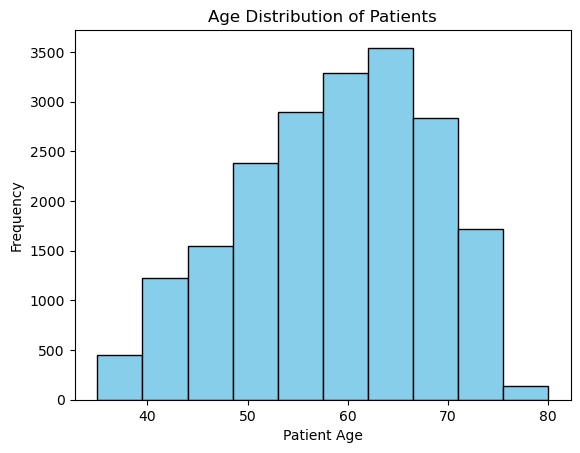

In [10]:
# Age distribution of patients 

#Group patient id and find their average age, as the journey could sometimes be in years
patient_age = round(data.groupby(['journey_id'])['patient_age'].mean(),1)
plt.hist(patient_age, bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Patients')

# Show the histogram
plt.show()

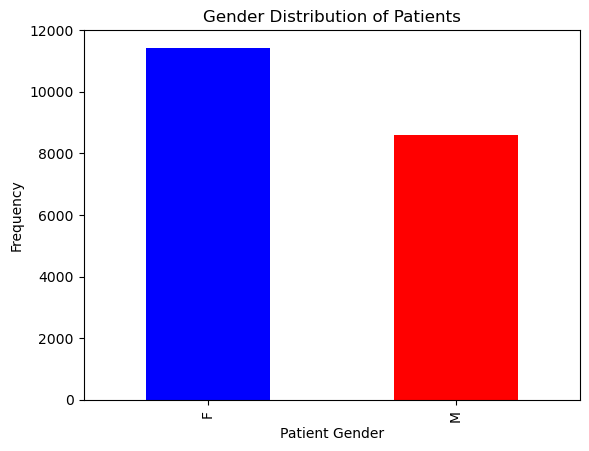

In [11]:
# Patient Gender Distribution 

gender = data.groupby(['journey_id'])['patient_gender'].first().value_counts()
gender.plot(kind='bar', color=['blue', 'red'])

plt.xlabel('Patient Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution of Patients')

# Show the histogram
plt.show()

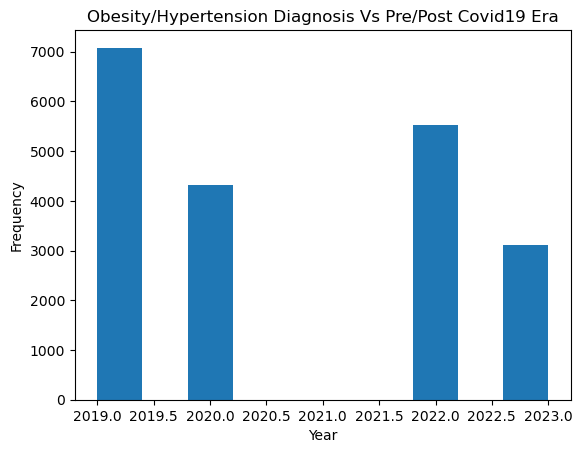

In [12]:
#Time when most people were first diagnosed to be Obese or Hypertensive 
data = data.sort_values(by='claim_date',ascending=True)
time = data[data['diag_list'].str.contains('E66|I10', na=False)].groupby(['journey_id'])['claim_date'].first()

plt.hist(pd.to_datetime(time).dt.year, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Obesity/Hypertension Diagnosis Vs Pre/Post Covid19 Era')
plt.show()

Text(0.5, 1.0, 'Place of service')

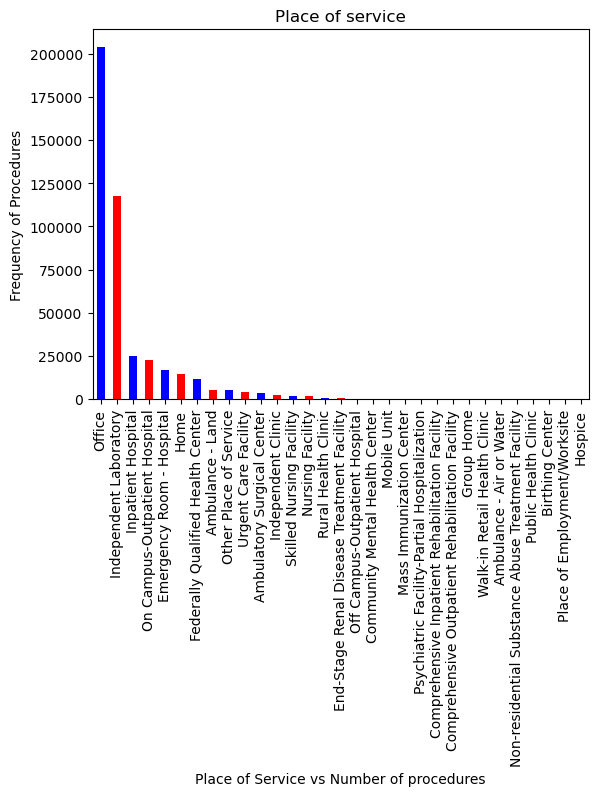

In [13]:
#Place of service distribution 

service_place = data['place_of_service'].value_counts()
service_place.plot(kind='bar', color=['blue', 'red'])

plt.xlabel('Place of Service vs Number of procedures')
plt.ylabel('Frequency of Procedures')
plt.title('Place of service')

In [14]:
# Let us explore the prescription data as well a little bit

#We are only interested in the prescription data for the patients who were obese or hypertensive in their journey 
filtered_pres = pres[pres['journey_id'].isin(pt_interest)]

#Filtering out and keep prescription data that only uses Ozempic. 

#This information was gathered in online for ndc11 codes for Ozempic, specifically to enrich our data. (* Additional Insights *)
ozem_ndc11 = ['169413001','169413013','169413211','169413212','169413290','169413297','169413602','169413611','169418103','169418113','169418190','169418197','169477211','169477212','169477290','169477297','5009051380','5009051390','5009060510','5009059490']

##Convert the datatype from int to object
filtered_pres['ndc11']=filtered_pres['ndc11'].astype('str')

data_pres = filtered_pres[filtered_pres['ndc11'].isin(ozem_ndc11)]

data_pres

/var/folders/6_/dr76lzfx6k97z9ld6s_cvxs00000gn/T/ipykernel_32658/1741388115.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pres['ndc11']=filtered_pres['ndc11'].astype('str')


,journey_id,cohort_id,claim_id,patient_gender,patient_state,patient_zip,patient_dob,pharmacy_npi,pharmacist_npi,prescriber_npi,...,bin,plan_pay,reject_code_1,reject_code_3,reject_code_4,reject_code_5,ndc,active,start_date,end_date
500,0003ff8dd03803a9197ed01075f4b094,16,c0f50d719ff896013509284426fc5a87487d13f536fc8f...,F,CA,922.0,1959-01-01,1.649295e+09,NaN,1669755153,...,4336.0,1006.98,NaN,NaN,NaN,NaN,169418113,True,190001,NaN
501,0003ff8dd03803a9197ed01075f4b094,16,38a682d6f8f8864e35733f6ad54cf8af48211243b74dab...,F,CA,922.0,1959-01-01,1.649295e+09,NaN,1669755153,...,4336.0,1006.98,NaN,NaN,NaN,NaN,169418113,True,190001,NaN
502,0003ff8dd03803a9197ed01075f4b094,16,0d32ea849bda5ff1cd2188e55c7ab95b02069be6dd98b0...,F,CA,922.0,1959-01-01,1.649295e+09,NaN,1669755153,...,4336.0,1006.98,NaN,NaN,NaN,NaN,169418113,True,190001,NaN
503,0003ff8dd03803a9197ed01075f4b094,16,e477a1fe8ef6108b7bc877735454fb6f4aa29b5b392779...,F,CA,922.0,1959-01-01,NaN,NaN,1669755153,...,4336.0,NaN,NaN,NaN,NaN,NaN,169418113,True,190001,NaN
1034,00056d978dce9b6f87ee68765b0f5cb2,16,c71ec95b504d2868b365018dc0663a5d6b6ce582674dfc...,F,CA,912.0,1954-01-01,1.538109e+09,NaN,1972921922,...,12312.0,829.32,NaN,NaN,NaN,NaN,169413212,True,190001,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894049,1ff8ff0a9c69c0d70e83a2061727c792,16,09a8c0431b5d67a80253d22146fb48efa339864761f21b...,F,CA,912.0,1968-01-01,1.942301e+09,NaN,1891244422,...,22659.0,871.08,NaN,NaN,NaN,NaN,169413013,True,190001,NaN
894095,1ff8ff0a9c69c0d70e83a2061727c792,16,8288447df8c673f868dcf1e435188e8a36912509560525...,F,CA,912.0,1968-01-01,1.942301e+09,NaN,1891244422,...,22659.0,913.27,NaN,NaN,NaN,NaN,169413013,True,190001,NaN
894102,1ff8ff0a9c69c0d70e83a2061727c792,16,09dcefc6e8654d6179ddf9d58a1d9f7cbb8bebb45b9437...,F,CA,912.0,1968-01-01,1.942301e+09,NaN,1891244422,...,22659.0,913.27,NaN,NaN,NaN,NaN,169413013,True,190001,NaN
894107,1ff8ff0a9c69c0d70e83a2061727c792,16,3732c0a9a379eb41e7b001210e59ee3a04a22253123a1c...,F,CA,912.0,1968-01-01,1.942301e+09,NaN,1891244422,...,22659.0,913.27,NaN,NaN,NaN,NaN,169413013,True,190001,NaN


In [15]:
#Check the null values 
print(data_pres.isnull().sum())

journey_id                          0
cohort_id                           0
claim_id                            0
patient_gender                      0
patient_state                       0
patient_zip                         0
patient_dob                         0
pharmacy_npi                      277
pharmacist_npi                   7338
prescriber_npi                     34
primary_care_npi                 7449
group_id                         4717
date_of_service                     0
date_authorized                   641
transaction_type                    0
date_prescription_written           0
ndc11                               0
ndc11_original                   6942
number_of_refills_authorized      200
diagnosis_code                   5625
diagnosis_code_type              6449
quantity_prescribed_original     4257
quantity_dispensed                  0
place_of_service                 4940
is_service                       1350
level_of_service                 6103
fill_number 

In [16]:
#Summarize the numeric columns under data_pres 
data_pres.describe()

,cohort_id,patient_zip,pharmacy_npi,pharmacist_npi,ndc11_original,number_of_refills_authorized,diagnosis_code_type,quantity_prescribed_original,quantity_dispensed,place_of_service,...,coupon_type,coupon_value_amount,pharmacy_submitted_cost,patient_pay,copay_coinsurance,bin,plan_pay,ndc,start_date,end_date
count,7460.000000,7460.000000,7.183000e+03,1.220000e+02,5.180000e+02,7260.000000,1011.0,3203.000000,7460.000000,2520.000000,...,179.0,0.0,6733.000000,4972.000000,3617.000000,6572.000000,4331.000000,7.460000e+03,7460.0,0.0
mean,16.050670,895.273324,1.512739e+09,1.554014e+09,5.592615e+07,2.518044,10.0,0.255698,3.031367,1.074206,...,88.0,NaN,1431.383591,39.582496,27.060276,166845.450548,992.082570,1.694212e+08,190001.0,NaN
std,0.219338,94.615114,2.705792e+08,2.443580e+08,7.974459e+07,3.442253,0.0,1.015739,2.013550,0.900603,...,0.0,NaN,905.412469,133.765132,72.336356,261670.449931,572.008026,2.030683e+04,0.0,NaN
min,16.000000,100.000000,1.003833e+09,1.053626e+09,0.000000e+00,0.000000,10.0,0.000000,1.000000,1.000000,...,88.0,NaN,0.000000,-60.000000,-897.050000,3585.000000,-73.730000,1.694130e+08,190001.0,NaN
25%,16.000000,900.000000,1.285145e+09,1.364284e+09,0.000000e+00,0.000000,10.0,0.000000,1.500000,1.000000,...,88.0,NaN,1072.000000,0.000000,0.000000,4336.000000,838.320000,1.694130e+08,190001.0,NaN
50%,16.000000,913.000000,1.508364e+09,1.689011e+09,0.000000e+00,2.000000,10.0,0.000000,3.000000,1.000000,...,88.0,NaN,1125.000000,4.300000,4.300000,20099.000000,900.830000,1.694132e+08,190001.0,NaN
75%,16.000000,922.000000,1.710998e+09,1.750760e+09,1.694132e+08,3.000000,10.0,0.000000,3.000000,1.000000,...,88.0,NaN,1362.500000,24.990000,30.000000,600426.000000,966.210000,1.694181e+08,190001.0,NaN
max,17.000000,957.000000,1.992742e+09,1.992465e+09,1.694181e+08,99.000000,10.0,12.000000,36.000000,12.000000,...,88.0,NaN,13477.000000,2485.770000,991.570000,610652.000000,6871.600000,1.694772e+08,190001.0,NaN


Text(0.5, 1.0, 'Start Dates of Prescription')

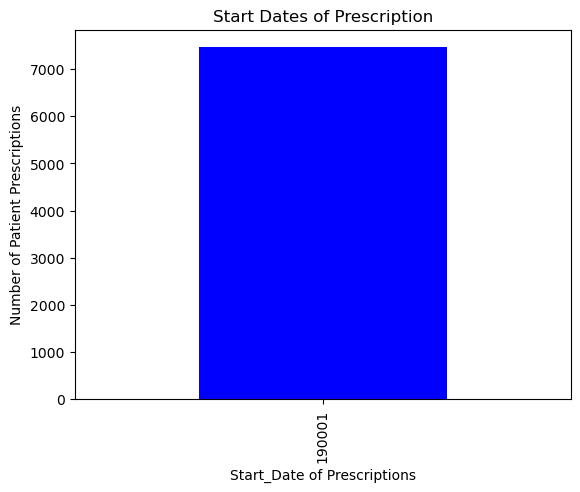

In [17]:
#Check the distribution of start_date of prescription 

start = data_pres['start_date'].value_counts()
start.plot(kind='bar', color=['blue', 'red'])

plt.xlabel('Start_Date of Prescriptions')
plt.ylabel('Number of Patient Prescriptions')
plt.title('Start Dates of Prescription')

### Insights from Data Exploration 

- The total number of patients observed under the claims data who are overweight/hypertensive is 27377.
- There are many missing values for most fields in the claims data. However, some of the can either be extrapolated or removed, as sufficient information is avaliable from others for time being.
- These obese/hypertensive patients are on average 59 years old.
- With the observed data, women tend to be larger in numbers for being obese/hypertensive than men. 
- The number of patients who newly reported being obese or hypertensive was lower than in the post than the pre-covid19 era. Maybe not everyone took a test after covid19 considering the spread. However, in 2023, it looks considerably low than all years for patient who found they're obese, as data may not be updated for the whole year.
- Surprisingly, a high no of procedures took place in the office followed by labarotaory, which could mean a number of them weren't serious procedures but could be precautious ones.
- We were able to find 7k+ indvidual prescription records for all the patients who are obese/hypertensive
- There is no reliable values for the start and end time of the patient journey for prescriptions as the start_time is just one value that is the same for all patients while end_time is not available for any patients.
- On average, 2.5 refills hapen for each prescription service for ozempic patients

## 2. Data Preprocessing and Merging

Before diving into filling missing values, or encoding categorical values, first let us merge the two datasets i.e the filtered claims and prescription for obese/hypertensive pateints using a sound logic. 

data (Filtered): Has information on all patients who were at any point were obese/hyperintensive in their journey.<br>
data_pres (Filtered): Has information for some or all the patients who are mentioned in the data_claims, and their prescription claims with ozempic. 

In [18]:
#Let us print all the ids i.e journey_id, cohort_id,claim_id for filtered prescription data for one particular customer journey
claim_id_test = data_pres[data_pres['journey_id']=='0003ff8dd03803a9197ed01075f4b094']['claim_id'].values
data_pres[data_pres['journey_id']=='0003ff8dd03803a9197ed01075f4b094'][['journey_id','cohort_id','claim_id']]


,journey_id,cohort_id,claim_id
500,0003ff8dd03803a9197ed01075f4b094,16,c0f50d719ff896013509284426fc5a87487d13f536fc8f...
501,0003ff8dd03803a9197ed01075f4b094,16,38a682d6f8f8864e35733f6ad54cf8af48211243b74dab...
502,0003ff8dd03803a9197ed01075f4b094,16,0d32ea849bda5ff1cd2188e55c7ab95b02069be6dd98b0...
503,0003ff8dd03803a9197ed01075f4b094,16,e477a1fe8ef6108b7bc877735454fb6f4aa29b5b392779...


In [19]:
#Let us test if any of the id columns in data (filtered claims) contains the claim_ids from prescription 

#Test for claim_ids and episode_ids
print(data[data['journey_id']=='0003ff8dd03803a9197ed01075f4b094']['episode_id'].isin(claim_id_test).value_counts())

#Test for claim_ids and visit_ids
print(data[data['journey_id']=='0003ff8dd03803a9197ed01075f4b094']['visit_id'].isin(claim_id_test).value_counts())

#Test for claim_ids and encounter_ids
print(data[data['journey_id']=='0003ff8dd03803a9197ed01075f4b094']['encounter_id'].isin(claim_id_test).value_counts())

episode_id
False    10
Name: count, dtype: int64
visit_id
False    10
Name: count, dtype: int64
encounter_id
False    10
Name: count, dtype: int64


None of the ids are directly related b/w these two datasets except the 'journey_id'.

In [20]:
print(f"The number of unqiue patients using ozempic prescription is {len(data_pres['journey_id'].unique())}.")

The number of unqiue patients using ozempic prescription is 738.


We can also look CPT codes for patients under claims (proc_code: 90471,96372), however it is more generic of procedures, and doesn't always end up in ozempic usage. So we'll just go ahead with data_pres with the information of our 738 patients. 

Note. This information about proc_codes was gathered online, specifically to enrich our data. (* Additional Insights *)

In [21]:
data_pres[data_pres['journey_id']=='1fde5a3198bb4313fea4a3123938ab2e'][['date_of_service','number_of_refills_authorized','quantity_dispensed','is_compound_drug']]

,date_of_service,number_of_refills_authorized,quantity_dispensed,is_compound_drug
890070,2022-04-08,0.0,4.5,False
890084,2022-07-29,3.0,3.0,False


Looking at the above table, it makes more sense to group the patients and understand their first date_of_service and sum all the quantity dispensed for our final prescription dataset. We are considering only these two features other than journey id itself, as it is more intutive in understanding the ozempic effect at the moment. 

In [22]:
def create_final_pres(df):
    result=pd.DataFrame()
    result['first_date_of_service']=[df['date_of_service'].values[0]]
    result['total_quantity_dispensed']=df['quantity_dispensed'].sum()
    result['treatment']=1
    return result

#Order the data_pres first by 'date_of_service'
data_pres = data_pres.sort_values(by='date_of_service',ascending=True)
final_pres = data_pres.groupby('journey_id').apply(create_final_pres).reset_index()
final_pres

,journey_id,level_1,first_date_of_service,total_quantity_dispensed,treatment
0,0003ff8dd03803a9197ed01075f4b094,0,2023-06-05,12.0,1
1,00056d978dce9b6f87ee68765b0f5cb2,0,2022-12-24,13.5,1
2,000855c2162997662fbc10d1f00da5ba,0,2023-05-03,12.0,1
3,001718e148712330cfeebee8f5481520,0,2022-02-21,33.0,1
4,00299f227060f67b076de5182f92fe4a,0,2023-01-06,37.5,1
...,...,...,...,...,...
733,1fd8bbfd597717dd02bfb770c6c7d118,0,2023-01-11,12.0,1
734,1fde5a3198bb4313fea4a3123938ab2e,0,2022-04-08,7.5,1
735,1fe9f2990d41963c763c83510553fb35,0,2022-02-01,111.0,1
736,1ff8fc83bf1796e9a601c6fdaaa5a3ef,0,2023-05-12,6.0,1


Now let us create an aggregated data for the data (filtered claims). At high level, we'll try to summarize the information of these obese patients especically considering the following features:<br> 1. First date of the journey<br>2. First date of obese/hypertension diagnosis<br>3. Recent/Last diagosis date<br>4. Recent or last diagnosis state <br>5. Age<br>6. Gender

In [23]:
def create_agg_data(df):
    result=pd.DataFrame()
    result['first_date']=[df['claim_date'].values[0]]
    result['first_date_diagnosed']=df[df['diag_list'].str.contains('E66|I10', na=False)].groupby(['journey_id'])['claim_date'].first().values[0]
    result['last_date_contact']=df['claim_date'].values[-1]
    result['last_status']=df['diag_list'].values[-1]
    result['age']=df['patient_age'].mean()
    result['gender']=df['patient_gender'].values[0]
    return result

#Order the data_oz by claim_date
data = data.sort_values(by='claim_date',ascending=True)

data_claim_final = data.groupby('journey_id').apply(create_agg_data).reset_index()

#We would also need to check and remove patients who only got diagnosed Obese / Hypertension at their last diagnosis, 
# or if it was their first and last diagnosis. Otherwise, we wouldn't know if these non-treated patients mitigated 
#the issues without ozempic or not.

time_columns = ['first_date','first_date_diagnosed','last_date_contact']
data_claim_final[time_columns] = data_claim_final[time_columns].apply(pd.to_datetime)
data_claim_final=data_claim_final[(data_claim_final['last_date_contact'] > data_claim_final['first_date_diagnosed'])]

data_claim_final

,journey_id,level_1,first_date,first_date_diagnosed,last_date_contact,last_status,age,gender
0,00006d564a4718c744f1bbf1b6c5f8c3,0,2019-11-01,2019-11-01,2023-08-11,N200,50.555556,F
2,00011020325337a2a22fb26b6492196a,0,2019-07-10,2019-07-10,2023-05-31,"R918,I517",73.070175,M
3,00012bb21b3136f52c1c0774071f2ec2,0,2023-01-20,2023-01-20,2023-02-03,"Z712,I10,E785,I259,F419,E669",50.000000,M
4,00025243850b83969606f3f2aafc2d99,0,2020-09-16,2022-07-21,2022-09-02,"Z03818,Z2089",69.000000,F
5,00028eaddd25f1151c94035997b5aab5,0,2019-09-13,2020-03-16,2022-04-18,"E119,E6609,I10,Z135,Z6831",66.176471,M
...,...,...,...,...,...,...,...,...
20023,1ffd79ac0b70c9bc6568944fbd52b88e,0,2019-01-14,2019-08-20,2023-09-15,"Z0000,Z7189,Z23,Z1211,I10,E663,I5032,I119",65.937500,M
20024,1ffdeeeb07ed99dca9658298d836e301,0,2020-12-31,2022-09-20,2023-08-22,R9720,62.285714,M
20025,1ffe48236d1f1abe1446b4fa382ca250,0,2022-08-05,2022-08-30,2022-10-25,R109,65.000000,M
20026,1fff36b69093f3ece1c2426183acaf31,0,2019-06-20,2019-06-20,2023-09-19,"U071,G4733",66.526316,F


In [24]:
#Let us go ahead and do an left join between data_claim_final and final_pres

final_data = pd.merge(data_claim_final, final_pres, on='journey_id', how='left')
final_data.drop(columns=['level_1_x','level_1_y'],inplace=True)
final_data

,journey_id,first_date,first_date_diagnosed,last_date_contact,last_status,age,gender,first_date_of_service,total_quantity_dispensed,treatment
0,00006d564a4718c744f1bbf1b6c5f8c3,2019-11-01,2019-11-01,2023-08-11,N200,50.555556,F,NaN,NaN,NaN
1,00011020325337a2a22fb26b6492196a,2019-07-10,2019-07-10,2023-05-31,"R918,I517",73.070175,M,NaN,NaN,NaN
2,00012bb21b3136f52c1c0774071f2ec2,2023-01-20,2023-01-20,2023-02-03,"Z712,I10,E785,I259,F419,E669",50.000000,M,NaN,NaN,NaN
3,00025243850b83969606f3f2aafc2d99,2020-09-16,2022-07-21,2022-09-02,"Z03818,Z2089",69.000000,F,NaN,NaN,NaN
4,00028eaddd25f1151c94035997b5aab5,2019-09-13,2020-03-16,2022-04-18,"E119,E6609,I10,Z135,Z6831",66.176471,M,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16870,1ffd79ac0b70c9bc6568944fbd52b88e,2019-01-14,2019-08-20,2023-09-15,"Z0000,Z7189,Z23,Z1211,I10,E663,I5032,I119",65.937500,M,NaN,NaN,NaN
16871,1ffdeeeb07ed99dca9658298d836e301,2020-12-31,2022-09-20,2023-08-22,R9720,62.285714,M,NaN,NaN,NaN
16872,1ffe48236d1f1abe1446b4fa382ca250,2022-08-05,2022-08-30,2022-10-25,R109,65.000000,M,NaN,NaN,NaN
16873,1fff36b69093f3ece1c2426183acaf31,2019-06-20,2019-06-20,2023-09-19,"U071,G4733",66.526316,F,NaN,NaN,NaN


In [25]:
#Now we just need to make sure that the first_date_of_service is on or after first_date_diagnosed 
#and first_date_of_service is less than last_date_contact for the ozempic patients to be reliable subjects 

pt_ozempic = final_pres['journey_id'].unique()
data_treat = final_data[final_data['journey_id'].isin(pt_ozempic)]

time_columns = ['first_date','first_date_diagnosed','last_date_contact','first_date_of_service']
data_treat[time_columns] = data_treat[time_columns].apply(pd.to_datetime)

#Check first_date_of_service and first_date_diagnosed
print(f"All the points satisfy our requirement i.e {len(data_treat['first_date_diagnosed']<data_treat['first_date_of_service'])}.")

#Check first_date_of_service and last_date_contact
print(f"All the points satisfy this requirement as well i.e {len(data_treat['last_date_contact']>data_treat['first_date_of_service'])}.")


All the points satisfy our requirement i.e 651.
All the points satisfy this requirement as well i.e 651.


/var/folders/6_/dr76lzfx6k97z9ld6s_cvxs00000gn/T/ipykernel_32658/2400346492.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_treat[time_columns] = data_treat[time_columns].apply(pd.to_datetime)


Now that all the checks are done, we can finalize the variables, start dealing with the null values, and encode the categorical variables

In [26]:
#Remove all the time columns + 'journey_id'
final_data.drop(columns=time_columns+['journey_id'],inplace=True)

In [27]:
print(final_data.isnull().sum())

last_status                   190
age                             2
gender                          5
total_quantity_dispensed    16224
treatment                   16224
dtype: int64


In [28]:
#Let us remove all the null value rows with last_status, age, and gender 

final_data.dropna(subset=['last_status','age','gender'], inplace=True)

In [29]:
#Let us fill the missing values with 0 for 'treatment'
final_data['treatment'].fillna(0, inplace=True)
final_data['treatment']=final_data['treatment'].astype(int)

#Let us fill the total_quantity_dispensed with 0 for NaN values 
final_data['total_quantity_dispensed'].fillna(0,inplace=True)

#Let us encode the gender to 0's and 1's
final_data['gender'] = final_data['gender'].map({'M': 1, 'F': 0})

#Let us encode the last_status to only 0's and 1's. 0's: Obese/Hypertensive, 1's: Not Obese/Hypertensive 
cond=final_data['last_status'].str.contains('E66|I10', na=False)
final_data['last_status'] = np.where(cond, 0, 1)

final_data

,last_status,age,gender,total_quantity_dispensed,treatment
0,1,50.555556,0,0.0,0
1,1,73.070175,1,0.0,0
2,0,50.000000,1,0.0,0
3,1,69.000000,0,0.0,0
4,0,66.176471,1,0.0,0
...,...,...,...,...,...
16870,0,65.937500,1,0.0,0
16871,1,62.285714,1,0.0,0
16872,1,65.000000,1,0.0,0
16873,1,66.526316,0,0.0,0


## 3. Casual Analysis Setup

Our current setup has,

##### Response variable: 
last_status (0-obesity/hypertension is present, 1-no obesity/hypertension is present)<br>
##### Treatment and Independent Variables/Confounders:
1. treatment (0 - no ozempic, 1 - ozempic)<br>
2. age (0 - Female, 1 - Male)
3. gender
4. total_quantity_dispensed (Although, some level of collinearity is possible here.)

Yes, there could be potential endogenity issues in the data. Endogenity usually arises when the residual error is correlated with any of the independent variables, which couuld attributed to model misspecification, missing variables etc. In our case, we tried to include all the 4 variables that made more sense to be included for a simple model that could help us find the treatment effect of ozempic on obese/hypertensive patients. So, to get a higher confidence estimate of treatment effect of ozempic on the target population, we need to make sure we have all the sound variables. But, there is a chance we might have missed few: how active is the individual in life (working out etc), lifestyle (9-5 job, or something different). There just so many variables that we could potentially miss in estimating a patient to be obese or hypertensive, and that issue won't fully perish, however we can try our best to mitigate it. 

To address the endogenity issues, we could include all the below variables/confounders along with the treatment variable in the model:<br>
1. Age (Age can affect how ozempic works, or can affect how people see obesity/hypertension, and work towards it)
2. Gender (Gender can affect how ozempic works, or can affect how people see obseity/hypertension, and work towards it)
3. Total Quantity Dispensed (This can affect how ozempic works i.e especially interaction effects, although it is not a confounder, it acts as partial IV in this case)

Whenever, we try to estimate the treatment effect with the observed data, it is best to have all the confounders to be included in the model so we can control them. Because, if these variables are not controlled, their effect will also be contributed as part of the treatment effect which will give us an biased estimation. To get a higher confidence for our estimation, we can use these confoudners with our treatment through a double lasso model, so that whatever treatment effect we get at the end is only because of the treatment itself. It is also good to note that we are only trying to get to the truth as close as much as possible, but not the truth itself. 

The thought process of including only these variables, not others like place_of_service, location etc. as we are trying to find the effect of a ozempic (chemical) which is not very intutively relatable to any of these, however the repsonse variable itself might be related to some of these such as place_of_service: office implies active people. But, keeping in mind only the confounders: that affects both response and treatment variable, we have come up with above with the available dataset.

## 4. Model Development: Double-Lasso/ Treatment Effect Lasso 

In [30]:
#Partial Lasso Class referred from Jacob 

class SelectiveRegularizationLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, penalty_indices, penalty_weights, tol=1e-4, max_iter=100):
        self.penalty_indices = penalty_indices
        self.penalty_weights = penalty_weights
        self.tol = tol
        self.max_iter = max_iter
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _predictions(self, coef, X):
        predictions = self._sigmoid(X @ coef)
        return predictions
        
    def _loss(self, coef, X, y):
        predictions = self._sigmoid(X @ coef)
        # Basic log loss
        basic_loss = log_loss(y, predictions)
        
        # Regularization term, selectively applied with L1 penalty
        reg_term = sum(self.penalty_weights[i] * abs(coef[self.penalty_indices[i]]) for i in range(len(self.penalty_indices)))
        
        return basic_loss + reg_term
    
    def fit(self, X, y):
        # Add intercept term
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        
        initial_coef = np.zeros(X.shape[1])
        result = minimize(self._loss, initial_coef, args=(X, y), method='SLSQP', tol=self.tol, options={'maxiter': self.max_iter})
        
        self.coef_ = result.x
        return self
    
    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        proba = self._sigmoid(X @ self.coef_)
        return np.vstack([1-proba, proba]).T
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

In [31]:
#Let us first apply Lasso regression of treatment on other X variables 

first_lasso = final_data.drop(['last_status'],axis=1)

In [32]:
#Let us ignore run time warnings, as it is a lot 
warnings.filterwarnings("ignore", category=RuntimeWarning)

X = first_lasso.drop(['treatment'], axis=1).values
y = first_lasso['treatment'].values

#Creating the lambda test values, as we have only few variables, we'll choose a smaller range for lambda testing
lambda_values= np.logspace(-2, 0, 30)

#Creating the train, test split for our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

best_lambda = None
lowest_loss = float('inf') #Setting the highest value for first conditional reference

penalty_indices = [0, 1,2]  # Apply penalties to all coefficients

#Run over different lambda values
for lambda_val in lambda_values:
    penalty_weights = [lambda_val] * len(penalty_indices)
    
    model = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
    model.fit(X_train, y_train)
    
    current_loss = model._loss(model.coef_[1:4], X_test, y_test)

    #If loss is the lowest, that lamda will be best lambda 
    if current_loss < lowest_loss:
        best_lambda = lambda_val
        lowest_loss = current_loss

print("Best Lambda:", best_lambda)
print("Lowest Loss:", lowest_loss)

Best Lambda: 0.01
Lowest Loss: 0.05662218352084479


In [33]:
#Our best lambda is 0.01, so let us rerun our model with the full dataset 

X = first_lasso.drop(['treatment'], axis=1).values
y = first_lasso['treatment'].values

penalty_indices = [0, 1,2]  # Apply penalties to all coefficients
penalty_weights = [0.01]*3  # Penalty weights for these coefficients

model_1 = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
model_1.fit(X, y)


#Predicting treatment on other confounding variables 
predictions = model_1._predictions(model.coef_[1:4],X)

In [34]:
#Add the predictions to the final_data

final_data['treatment_hat']=predictions

In [35]:
#Let us now do the second lasso 

second_lasso=final_data.copy()

In [36]:
#Let us ignore run time warnings, as it is a lot 
warnings.filterwarnings("ignore", category=RuntimeWarning)

X = second_lasso.drop(['last_status'], axis=1).values
y = second_lasso['last_status'].values

#Creating the lambda test values, as we have only few variables, we'll choose a smaller range for lambda testing
lambda_values= np.logspace(-2, 0, 30)

#Creating the train, test split for our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

best_lambda = None
lowest_loss = float('inf') #Setting the highest value for first conditional reference

penalty_indices = [0, 1,2,3]  # Apply penalties to all coefficients except the last one (treatment_hat)

#Run over different lambda values
for lambda_val in lambda_values:
    penalty_weights = [lambda_val] * len(penalty_indices)
    
    model = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
    model.fit(X_train, y_train)
    
    current_loss = model._loss(model.coef_[1:6], X_test, y_test)

    #If loss is the lowest, that lamda will be best lambda 
    if current_loss < lowest_loss:
        best_lambda = lambda_val
        lowest_loss = current_loss

print("Best Lambda:", best_lambda)
print("Lowest Loss:", lowest_loss)

Best Lambda: 0.0117210229753348
Lowest Loss: 0.658340844653251


In [37]:
#Our best lambda is 0.01, so let us rerun our model with the full dataset 

X = second_lasso.drop(['last_status'], axis=1).values
y = second_lasso['last_status'].values

penalty_indices = [0, 1,2,3]  # Apply penalties to all coefficients
penalty_weights = [0.01]*4  # Penalty weights for these coefficients

model_2 = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
model_2.fit(X, y)


model_2.coef_

array([-0.00117273,  0.00896429, -0.00173741,  0.00174391,  0.00229464,
        0.0027168 ])

In [38]:
print(f"The treatment effect we observe is {round(model_2.coef_[4],3)} (i.e the co-efficient of our treatment variable in our second model).")

The treatment effect we observe is 0.002 (i.e the co-efficient of our treatment variable in our second model).


While we have dicussed majorely about variables we took from claims, and prescription data and the reason behind it in section 3, we'll focus more on what is happening with the available variables during the double lasso. 

First Lasso - (Treatment(ozempic) on X variables: Age, Gender, Total Quantity Dispensed):
<br>- Here, we're trying to regress our treatment on other confounding variables (X). The idea is to visualize whatever residual error we get from this model can be attributed to the treatment alone. So, we make the predictions from this model (treatment_hat), and use it for second lasso. 

<br>Second Lasso - (Response (Obese/Hypertensive) on variables: Age, Gender, Total Quantity Dispensed, Treatment, Treatment_hat):
<br>- Here, we're trying to regress our response variable on treatment, predicted_treatment, and other confounding variables. Here, the treatment coefficient will be our true treatment coefficient because we are including the predicted_treatment which will control the effects for the confouding factors under our treatment with the help of inclusion of treatment_hat. So whatever coefficient we get for our treatment is our treatment effect. The reason for not assigning any weights to the treatment_hat is because we want to control fully, and with Lasso, sometimes they could be removed, hence they're not being included the weighting parts.

## 5. Model Evaluation and Interpretation

In [39]:
model_2._loss(model_2.coef_[1:6], X, y)


0.6575157826598244

Fitted loss(or deviance) is almost similar to our test deviation. So, we can say this is the best we got at the moment. Although, this can be comapared with other models by using CV, here we only used one train and test set due to small sample of treatment. Ideally, we can also build up on multinomial regression than logistici regression, as we can try to fit the ozempic effect with patients who are obese, or hypertensive, or neither, which could also get us a better model. 

<br> The estimated treatment effect is represented in log odd i.e for every person (or patient) who takes ozempic, there is a log odds of not being obese to obese is 0.002. To put it more simply, when a person takes ozempic, there is only 0.2% chance that it will help them become not obese/hypertensive, and when we look at it on high level is merely an 50% chance of being obese/hypertensive or not.  This much low number indicates or the odds of 1, it tells that there may not be significant causal effect for practical purposes. 

To summarize, on average people who tend to be obese or hypertensive are able to mitigate obesity or hyptertension with ozempic is not any different to any other methods they go through (other medications, self cure etc). But, before finalizing that Ozempic is not significantly producing any effect, we could try to gather more information, and analyze or ideally try an experiment to determine the effects.
